In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

RAV = '/content/drive/MyDrive/Colab Notebooks/DATASETS/RAVDESS Dataset/'

# Run one example 
dir_list = os.listdir(RAV)
dir_list[0:5]

['Actor_21', 'Actor_19', 'Actor_15', 'Actor_16', 'Actor_17']

In [ ]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_surprise       96
male_disgust        96
male_fear           96
female_happy        96
female_angry        96
female_fear         96
female_sad          96
female_disgust      96
female_surprise     96
Name: labels, dtype: int64

In [ ]:
df = RAV_df
print(df.labels.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_surprise       96
male_disgust        96
male_fear           96
female_happy        96
female_angry        96
female_fear         96
female_sad          96
female_disgust      96
female_surprise     96
Name: labels, dtype: int64


# **Build Model**

In [ ]:
!pip install utils

In [ ]:
!pip install np_utils

In [ ]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [ ]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("./Data_path.csv")
ref.head()

,labels,source,path
0,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...
1,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...
2,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...
3,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...
4,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...


In [ ]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  ,res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1440


,feature
0,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
1,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-67.55739, -67.55739, -67.55739, -67.55739, -..."


In [ ]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082737,-60.234661
1,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,-58.299904,-62.295246,-64.930115,-65.332123,-64.116928,-64.319908,-64.971420,-63.155781,-64.178665,-63.061893
2,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,...,-65.818863,-65.818863,-65.818863,-65.818863,-65.438057,-65.684853,-65.818863,-65.818863,-65.818863,-65.818863
3,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,-57.539616,-55.826317,-57.741989,-59.796379,-60.975368,-62.663052,-64.573494,-63.782608,-61.515789,-58.214882
4,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,...,-57.451920,-57.270752,-56.743652,-56.140930,-57.532017,-59.493046,-67.149849,-67.498711,-66.086418,-66.205048


In [ ]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(1440, 219)


,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-58.802044,-57.447464,-58.896500,-58.750996,-57.405678,-60.078484,-63.426800,-62.638542,-61.082737,-60.234661
1,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,-58.299904,-62.295246,-64.930115,-65.332123,-64.116928,-64.319908,-64.971420,-63.155781,-64.178665,-63.061893
2,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,...,-65.818863,-65.818863,-65.818863,-65.818863,-65.438057,-65.684853,-65.818863,-65.818863,-65.818863,-65.818863
3,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,-57.539616,-55.826317,-57.741989,-59.796379,-60.975368,-62.663052,-64.573494,-63.782608,-61.515789,-58.214882
4,male_neutral,RAVDESS,/content/drive/MyDrive/Colab Notebooks/DATASET...,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-67.557388,-65.239815,...,-57.451920,-57.270752,-56.743652,-56.140930,-57.532017,-59.493046,-67.149849,-67.498711,-66.086418,-66.205048


In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1050,-61.714115,-61.714115,-61.714115,-61.714115,-61.714115,-61.714115,-61.714115,-61.714115,-61.714115,-61.714115,...,-55.311993,-56.966789,-57.449875,-58.755390,-59.028950,-59.472717,-59.235733,-58.696953,-57.251286,-55.447670
1089,-71.995422,-71.995422,-68.677322,-70.496414,-67.636055,-59.928894,-55.650288,-52.937420,-52.056358,-51.702621,...,-64.137955,-62.674458,-60.765366,-60.234379,-61.843319,-66.740082,-63.569099,-66.965347,-71.980331,-71.995422
1272,-52.029785,-49.040154,-49.723259,-53.390770,-56.820419,-60.676460,-62.403404,-61.366428,-58.114830,-57.006554,...,-57.032383,-57.066837,-56.801228,-59.784161,-61.799107,-61.976730,-62.287128,-61.755066,-62.131077,-66.521088
1029,-39.220127,-38.967705,-38.299438,-39.797867,-40.150063,-41.485416,-40.066025,-40.926144,-41.405636,-41.089012,...,-30.336693,-32.799198,-38.420895,-38.816059,-39.434536,-40.608852,-40.189308,-41.060795,-42.711063,-42.362637
1336,-52.988201,-53.102032,-53.116905,-53.790546,-54.014877,-54.485970,-54.411587,-54.115250,-52.942505,-52.026791,...,-52.816769,-53.352226,-54.098373,-53.875473,-54.247341,-54.239586,-53.348457,-53.820827,-54.235146,-54.240383
328,-49.203651,-43.896511,-42.766781,-42.542843,-43.345558,-44.991421,-42.976730,-42.368595,-43.346909,-46.099033,...,-45.238987,-45.391239,-47.429379,-46.739872,-47.317589,-49.158272,-49.950569,-49.553352,-41.488201,-34.081284
318,-47.663139,-47.677933,-47.639645,-47.585575,-47.357380,-47.152390,-46.562134,-45.171509,-44.318325,-44.852592,...,-42.012383,-40.152534,-41.010311,-40.839905,-41.635464,-41.761421,-41.185459,-41.830139,-44.060730,-44.244766
1108,-42.913452,-42.200279,-42.496864,-43.456383,-42.862217,-43.401558,-45.431980,-46.090488,-46.090488,-46.090488,...,-24.652851,-25.508823,-26.493610,-26.490438,-29.129559,-31.096128,-31.046099,-32.393894,-33.771416,-38.168930
1176,-53.872322,-53.872322,-53.872322,-53.872322,-53.872322,-53.872322,-53.872322,-53.872322,-53.872322,-53.773628,...,-39.164860,-38.768677,-38.717068,-39.163143,-38.291248,-39.560226,-40.503494,-42.248745,-41.429447,-41.248676
12,-58.731003,-58.746517,-58.048584,-57.370796,-58.199924,-59.706638,-59.876179,-59.998066,-59.936649,-60.248569,...,-54.060478,-50.477974,-50.955284,-55.110638,-53.636642,-57.134220,-58.249916,-56.417946,-54.576744,-51.933964


In [ ]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
1050,-0.684263,-0.716231,-0.724023,-0.729274,-0.726523,-0.724955,-0.716102,-0.716061,-0.724382,-0.728849,...,-0.784547,-0.901417,-0.919688,-1.006938,-1.015848,-1.043936,-0.998681,-0.927014,-0.773012,-0.595968
1089,-1.889035,-1.936579,-1.560981,-1.786882,-1.435585,-0.513287,-0.007077,0.310899,0.406855,0.442465,...,-1.537622,-1.385935,-1.199963,-1.132286,-1.254869,-1.666378,-1.369880,-1.638127,-1.919656,-1.759257
1272,0.450555,0.788117,0.717242,0.273065,-0.140578,-0.601924,-0.796699,-0.675378,-0.302789,-0.178079,...,-0.931340,-0.909910,-0.864855,-1.094129,-1.251114,-1.258402,-1.260065,-1.190023,-1.152900,-1.374417
1029,1.951601,1.983675,2.090352,1.909990,1.855443,1.673496,1.815144,1.716337,1.654400,1.684225,...,1.346469,1.150148,0.688925,0.682962,0.648283,0.571735,0.632847,0.589764,0.358932,0.323895
1336,0.338247,0.305988,0.309336,0.224922,0.195343,0.132062,0.137760,0.173082,0.303058,0.404538,...,-0.571643,-0.594580,-0.636369,-0.593355,-0.609751,-0.595724,-0.494374,-0.507648,-0.538208,-0.511098
328,0.781723,1.398646,1.553391,1.579426,1.472831,1.257800,1.474804,1.547556,1.427014,1.098068,...,0.074931,0.081221,-0.072607,0.011402,-0.021215,-0.160514,-0.203309,-0.140629,0.454131,0.906064
318,0.962242,0.949807,0.967687,0.972155,0.992477,1.001581,1.055573,1.219588,1.313229,1.243897,...,0.350241,0.525930,0.470029,0.511437,0.461361,0.473019,0.547516,0.523597,0.253861,0.191583
1108,1.518814,1.599982,1.585834,1.469413,1.530704,1.446305,1.187719,1.112058,1.105651,1.099067,...,1.831443,1.769021,1.697196,1.727585,1.523473,1.386490,1.416059,1.335150,1.054876,0.618707
1176,0.234645,0.214558,0.218537,0.215074,0.212412,0.204821,0.200815,0.201507,0.194146,0.200163,...,0.593206,0.643404,0.663888,0.653546,0.745381,0.661549,0.605933,0.487595,0.458704,0.402205
12,-0.334700,-0.363989,-0.283437,-0.206230,-0.305752,-0.486935,-0.501198,-0.515266,-0.516183,-0.557385,...,-0.677762,-0.350587,-0.370669,-0.698038,-0.557885,-0.843646,-0.914235,-0.731010,-0.564801,-0.348959


In [ ]:

from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


In [ ]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1080, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [ ]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 216, 1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape)

(864, 216, 1) (864, 14) (216, 216, 1) (216, 14) (360, 216, 1) (360, 14)


In [ ]:
from tensorflow.keras.optimizers import Adam,RMSprop

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))

model.add(BatchNormalization())
model.add(Conv1D(256, 8, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(MaxPooling1D(pool_size=(8)))

# model.add(Conv1D(128, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

# model.add(BatchNormalization())
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# model.add(BatchNormalization())
# model.add(Conv1D(64, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

# model.add(BatchNormalization())
# model.add(Conv1D(32, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

# model.add(BatchNormalization())
# model.add(Conv1D(32, 8, padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(120))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(Activation('relu'))

model.add(Dense(80))
model.add(Activation('relu'))

model.add(Dense(60))
model.add(Activation('relu'))

model.add(Dense(40))
model.add(Activation('relu'))

model.add(Dense(20))
model.add(Activation('relu'))

model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))

#opt = tf.keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt = tf.keras.optimizers.Adam(lr=0.0001)
#opt = tf.keras.optimizers.RMSprop(lr=0.0002, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(filepath='emotiondetection_cnn.h5', verbose=2, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,
                        batch_size=32, epochs=100,
                        validation_data=(X_valid, y_valid), shuffle=True , verbose=2, callbacks=[checkpoint,earlystopping])

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.66296, saving model to emotiondetection_cnn.h5
27/27 - 4s - loss: 1.2345 - accuracy: 0.5451 - val_loss: 1.6630 - val_accuracy: 0.4398 - 4s/epoch - 135ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.66296 to 1.65789, saving model to emotiondetection_cnn.h5
27/27 - 1s - loss: 1.2631 - accuracy: 0.5289 - val_loss: 1.6579 - val_accuracy: 0.4444 - 1s/epoch - 51ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.65789 to 1.65316, saving model to emotiondetection_cnn.h5
27/27 - 1s - loss: 1.2470 - accuracy: 0.5648 - val_loss: 1.6532 - val_accuracy: 0.4491 - 1s/epoch - 52ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.65316 to 1.64944, saving model to emotiondetection_cnn.h5
27/27 - 1s - loss: 1.2070 - accuracy: 0.5579 - val_loss: 1.6494 - val_accuracy: 0.4676 - 1s/epoch - 50ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.64944 to 1.64787, saving model to emotiondetection_cnn.h5
27/27 - 1s - loss: 1.2444 - accuracy: 

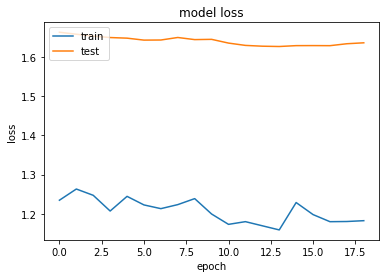

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model.h5 


In [ ]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
#opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 42.22%


In [ ]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

23/23 [==============================] - 0s 8ms/step


array([ 8, 13,  3,  4,  7, 10,  6,  2,  2, 11,  3,  2, 11,  6,  0,  2,  4,
       10,  4,  6,  2,  2,  4,  8,  5, 11, 11, 11,  7, 11,  7,  3, 10,  7,
       13, 13,  8,  7,  2, 10,  6, 11,  6,  6, 13, 13,  0, 11,  5,  4,  8,
        6, 13,  0,  7,  3,  5,  6, 10, 11, 11,  5, 13,  6,  5,  4,  1, 11,
        4,  1,  5,  6,  5,  4, 11,  7, 11, 10,  7,  0, 11,  4,  0,  3,  4,
       11,  5,  4, 11,  1,  5,  4,  6,  2, 13, 12,  6, 11,  4, 10,  4,  8,
       11,  9,  8,  7,  4,  0,  8, 11,  2,  5,  0, 11,  6,  6,  7, 13, 11,
       13,  2,  4,  5,  7, 10, 11,  1, 12,  6,  4, 10, 10, 11, 13,  5, 11,
        5,  8,  2,  0, 11,  4,  1, 11, 12,  9, 11,  9, 13,  4,  8,  4,  4,
        8,  5,  8,  5, 11,  8,  0,  8, 11,  5,  3,  6,  4, 13,  6,  6,  2,
        1, 13,  2,  3,  7,  4,  8,  8, 13,  4,  5,  5,  4,  3,  6, 11,  6,
        4,  0,  7, 10,  3,  3,  4,  7,  0,  8,  6,  6,  0,  0, 12, 13,  4,
        7,  0,  7,  5,  7, 11,  3,  8,  0,  5,  2,  3,  6,  4,  6,  0,  4,
        8,  4,  6, 11,  2

In [ ]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_happy,female_disgust
171,male_surprise,male_surprise
172,female_angry,female_fear
173,female_happy,female_happy
174,male_angry,male_angry
175,female_neutral,female_neutral
176,male_disgust,male_disgust
177,male_fear,male_disgust
178,male_angry,male_surprise
179,female_neutral,female_neutral


In [ ]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_disgust,11
female_fear,19
female_happy,23
female_neutral,51
female_sad,31
female_surprise,37
male_angry,32
male_disgust,31


In [ ]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.4222222222222222


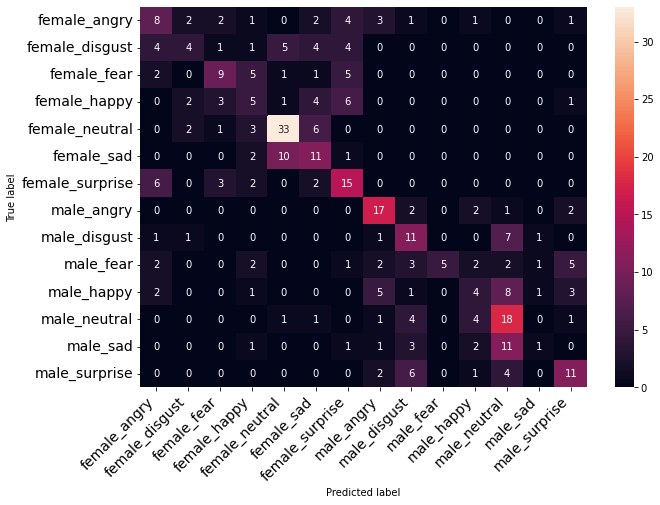

In [ ]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.32      0.32      0.32        25
 female_disgust       0.36      0.17      0.24        23
    female_fear       0.47      0.39      0.43        23
   female_happy       0.22      0.23      0.22        22
 female_neutral       0.65      0.73      0.69        45
     female_sad       0.35      0.46      0.40        24
female_surprise       0.41      0.54      0.46        28
     male_angry       0.53      0.71      0.61        24
   male_disgust       0.35      0.50      0.42        22
      male_fear       1.00      0.20      0.33        25
     male_happy       0.25      0.16      0.20        25
   male_neutral       0.35      0.60      0.44        30
       male_sad       0.25      0.05      0.08        20
  male_surprise       0.46      0.46      0.46        24

       accuracy                           0.42       360
      macro avg       0.43      0.39      0.38       360
   weighted avg       0.44   

0.9416666666666667


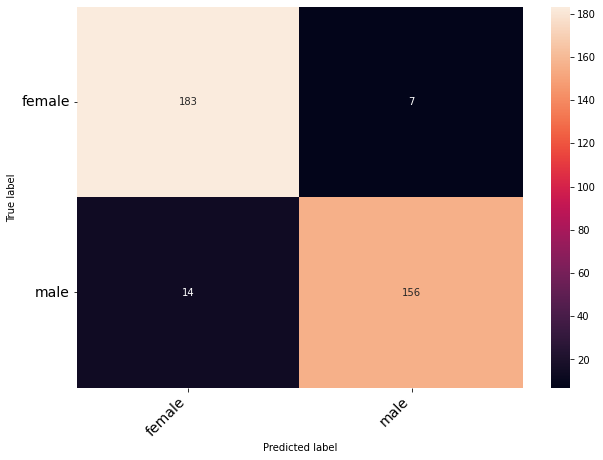

In [ ]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.93      0.96      0.95       190
        male       0.96      0.92      0.94       170

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



0.4388888888888889


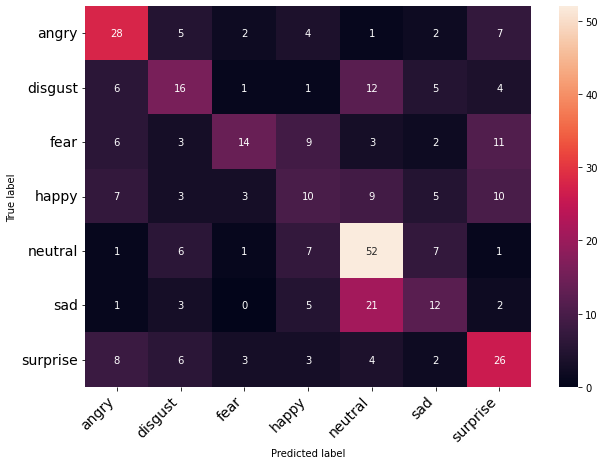

In [ ]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [ ]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.49      0.57      0.53        49
     disgust       0.38      0.36      0.37        45
        fear       0.58      0.29      0.39        48
       happy       0.26      0.21      0.23        47
     neutral       0.51      0.69      0.59        75
         sad       0.34      0.27      0.30        44
    surprise       0.43      0.50      0.46        52

    accuracy                           0.44       360
   macro avg       0.43      0.41      0.41       360
weighted avg       0.44      0.44      0.43       360



In [ ]:
from keras.models import Sequential, Model, model_from_json
import matplotlib.pyplot as plt
import keras 
import pickle
import wave  # !pip install wave
import os
import pandas as pd
import numpy as np
import sys
import warnings
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:

# data, sampling_rate = librosa.load('../input/cremad/AudioWAV/1001_DFA_DIS_XX.wav')
ipd.Audio('/content/drive/MyDrive/Colab Notebooks/DATASETS/RAVDESS Dataset/Actor_01/03-01-01-01-01-01-01.wav')

In [ ]:
# loading json and model architecture 
json_file = open('./model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = tf.keras.optimizers.Adam(lr=0.00001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# loading json and model architecture 
json_file = open('./model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("./saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = tf.keras.optimizers.Adam(lr=0.00001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
